<a href="https://colab.research.google.com/github/abdullahzunorain/legal-case-summarizer-chatbot/blob/main/Legal_Case_Summarizer_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Install Dependencies

In [1]:
# !pip install transformers sentence-transformers faiss-cpu streamlit datasets
# !pip install kagglehub
# !pip install pdfplumber torch
!pip install transformers sentence-transformers faiss-cpu streamlit datasets kagglehub pdfplumber torch


In [2]:
import faiss
import torch
import streamlit as st
import numpy as np
from datasets import load_dataset
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from transformers import T5ForConditionalGeneration, T5Tokenizer

## Check if GPU is available

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Step 2: Load the Dataset (Extract Relevant Text)

In [4]:
# Load a subset of the LEDGAR dataset for demonstration
dataset = load_dataset("lex_glue", "ledgar", split="train[:500]")

# Extract relevant text fields from the dataset for summarization
documents = [entry["text"] for entry in dataset]


README.md:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/20.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.31M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.44M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
print(documents)

['Except as otherwise set forth in this Debenture, the Company, for itself and its legal representatives, successors and assigns, expressly waives presentment, protest, demand, notice of dishonor, notice of nonpayment, notice of maturity, notice of protest, presentment for the purpose of accelerating maturity, and diligence in collection.', 'No ERISA Event has occurred or is reasonably expected to occur that, when taken together with all other such ERISA Events for which liability is reasonably expected to occur, could reasonably be expected to result in a Material Adverse Effect. Neither Borrower nor any ERISA Affiliate maintains or contributes to or has any obligation to maintain or contribute to any Multiemployer Plan or Plan, nor otherwise has any liability under Title IV of ERISA.', 'This Amendment may be executed by one or more of the parties hereto on any number of separate counterparts, and all of said counterparts taken together shall be deemed to constitute one and the same i

## Step 3: Load the Pre-trained T5 Model and Tokenizer / Load the Retrieval Model

In [6]:
# Load the retrieval model
retriever_model = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v3').to(device)

# Encode documents and convert to tensor format for compatibility
doc_embeddings = retriever_model.encode(documents, convert_to_tensor=True).cpu().numpy()

# Move tensor to CPU and convert to NumPy for FAISS compatibility
# doc_embeddings_cpu = doc_embeddings.cpu().numpy()

# Initialize FAISS index
dimension = doc_embeddings.shape[1]  # embedding dimension
index = faiss.IndexFlatL2(dimension)     # L2 distance for similarity
index.add(doc_embeddings)            # add document embeddings to index

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/499 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Step 4: Define a Retrieval Function

In [7]:
# Document retrieval function
def retrieve_documents(query, top_k=5):
    # Encode the query on the specified device
    query_embedding = retriever_model.encode([query], convert_to_tensor=True).cpu().numpy()

    # Perform FAISS search
    distances, indices = index.search(query_embedding, top_k)
    results = [{"text": documents[idx], "score": distances[0][i]} for i, idx in enumerate(indices[0])]
    return results

## Step 5: Load Summarization Model

In [8]:
# Load summarization model, set it to GPU if available
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0 if torch.cuda.is_available() else -1)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Step 6: Define Summarization function

In [9]:
# Updated Summarization function with dynamic max_length
def summarize_text(text):
    input_length = len(text.split())
    max_length = min(150, int(input_length * 0.6))  # Set max_length to 60% of the input length
    min_length = min(30, int(input_length * 0.3))   # Set min_length to 30% of the input length

    summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

## Step 7: Function to retrieve and summarize documents

In [10]:
# Function to retrieve and summarize documents
def retrieve_and_summarize(query, top_k=5):
    # Retrieve documents
    retrieved_docs = retrieve_documents(query, top_k)

    # Summarize each retrieved document
    summaries = []
    for doc in retrieved_docs:
        summary = summarize_text(doc['text'])
        summaries.append({"original": doc['text'], "summary": summary, "score": doc['score']})

    return summaries

In [11]:
# Example query and retrieve-and-summarize process remains the same
query = "Summarize a case related to contract law."
results = retrieve_and_summarize(query, top_k=3)

# Display results
for i, result in enumerate(results):
    print(f"Document {i+1}:")
    print("Original Text:", result['original'])
    print("Summary:", result['summary'])
    print("Score:", result['score'])
    print("-" * 80)

Document 1:
Original Text: This Agreement and the other Loan Documents and any claims, controversy, dispute or cause of action (whether in contract or tort or otherwise) based upon, arising out of or relating to this Agreement or any other Loan Document (except, as to any other Loan Document, as expressly set forth therein) and the transactions contemplated hereby and thereby shall be governed by, and construed in accordance with, internal laws of the State of Illinois (including, without limitation, 735 ILCS Section 105/5-1 et seq., but otherwise without regard to the conflict of laws provisions) of the State of Illinois.
Summary: This Agreement and the other Loan Documents and any claims, controversy, dispute or cause of action (whether in contract or tort or otherwise) based upon, arising out of or relating to this Agreement or any other Loan Document will be governed by the internal laws of the State of Illinois
Score: 157.07181
-----------------------------------------------------

## Step 5: Create the Streamlit Application


In [13]:
import streamlit as st
import torch
import faiss
import numpy as np
from datasets import load_dataset
from transformers import pipeline
from sentence_transformers import SentenceTransformer

# Load a subset of the LEDGAR dataset for demonstration
dataset = load_dataset("lex_glue", "ledgar", split="train[:500]")
documents = [entry["text"] for entry in dataset]

# Check if GPU is available (for Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the retrieval model
retriever_model = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v3', device=device)
doc_embeddings = retriever_model.encode(documents, convert_to_tensor=True).cpu().numpy()  # Move to CPU after encoding if on GPU

# Initialize FAISS index
dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(doc_embeddings)

# Document retrieval function
def retrieve_documents(query, top_k=5):
    query_embedding = retriever_model.encode([query], convert_to_tensor=True).cpu().numpy()
    distances, indices = index.search(query_embedding, top_k)
    results = [{"text": documents[idx], "score": distances[0][i]} for i, idx in enumerate(indices[0])]
    return results

# Load summarization model, set to GPU if available, otherwise fallback to CPU
summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0 if torch.cuda.is_available() else -1)

# Summarization function with dynamic length
def summarize_text(text):
    input_length = len(text.split())
    max_length = min(150, int(input_length * 0.6))
    min_length = min(30, int(input_length * 0.3))
    summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
    return summary[0]['summary_text']

# Retrieve and summarize function
def retrieve_and_summarize(query, top_k=5):
    retrieved_docs = retrieve_documents(query, top_k)
    summaries = []
    for doc in retrieved_docs:
        summary = summarize_text(doc['text'])
        summaries.append({"original": doc['text'], "summary": summary, "score": doc['score']})
    return summaries

# Streamlit app structure
st.title("Legal Case Summarizer")
query = st.text_input("Enter a legal topic or question:")
if query:
    st.write("Retrieving and summarizing...")
    results = retrieve_and_summarize(query, top_k=3)
    for i, result in enumerate(results):
        st.subheader(f"Document {i+1}")
        st.write("Original Text:", result['original'])
        st.write("Summary:", result['summary'])
        st.write("Score:", result['score'])


2024-11-07 07:26:53.459 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-07 07:26:53.785 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-11-07 07:26:53.786 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-07 07:26:53.789 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-07 07:26:53.794 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-07 07:26:53.795 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-07 07:26:53.798 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-07 07:26:53.799 Session state does not 

In [16]:
!wget -q -O - ipv4.icanhazip.com

35.227.172.32


In [17]:
!streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.227.172.32:8501

your url is: https://puny-aliens-invite.loca.lt
2024-11-07 07:32:35.918963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 07:32:35.941898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 07:32:35.948745: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 07:32:37.445865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/py

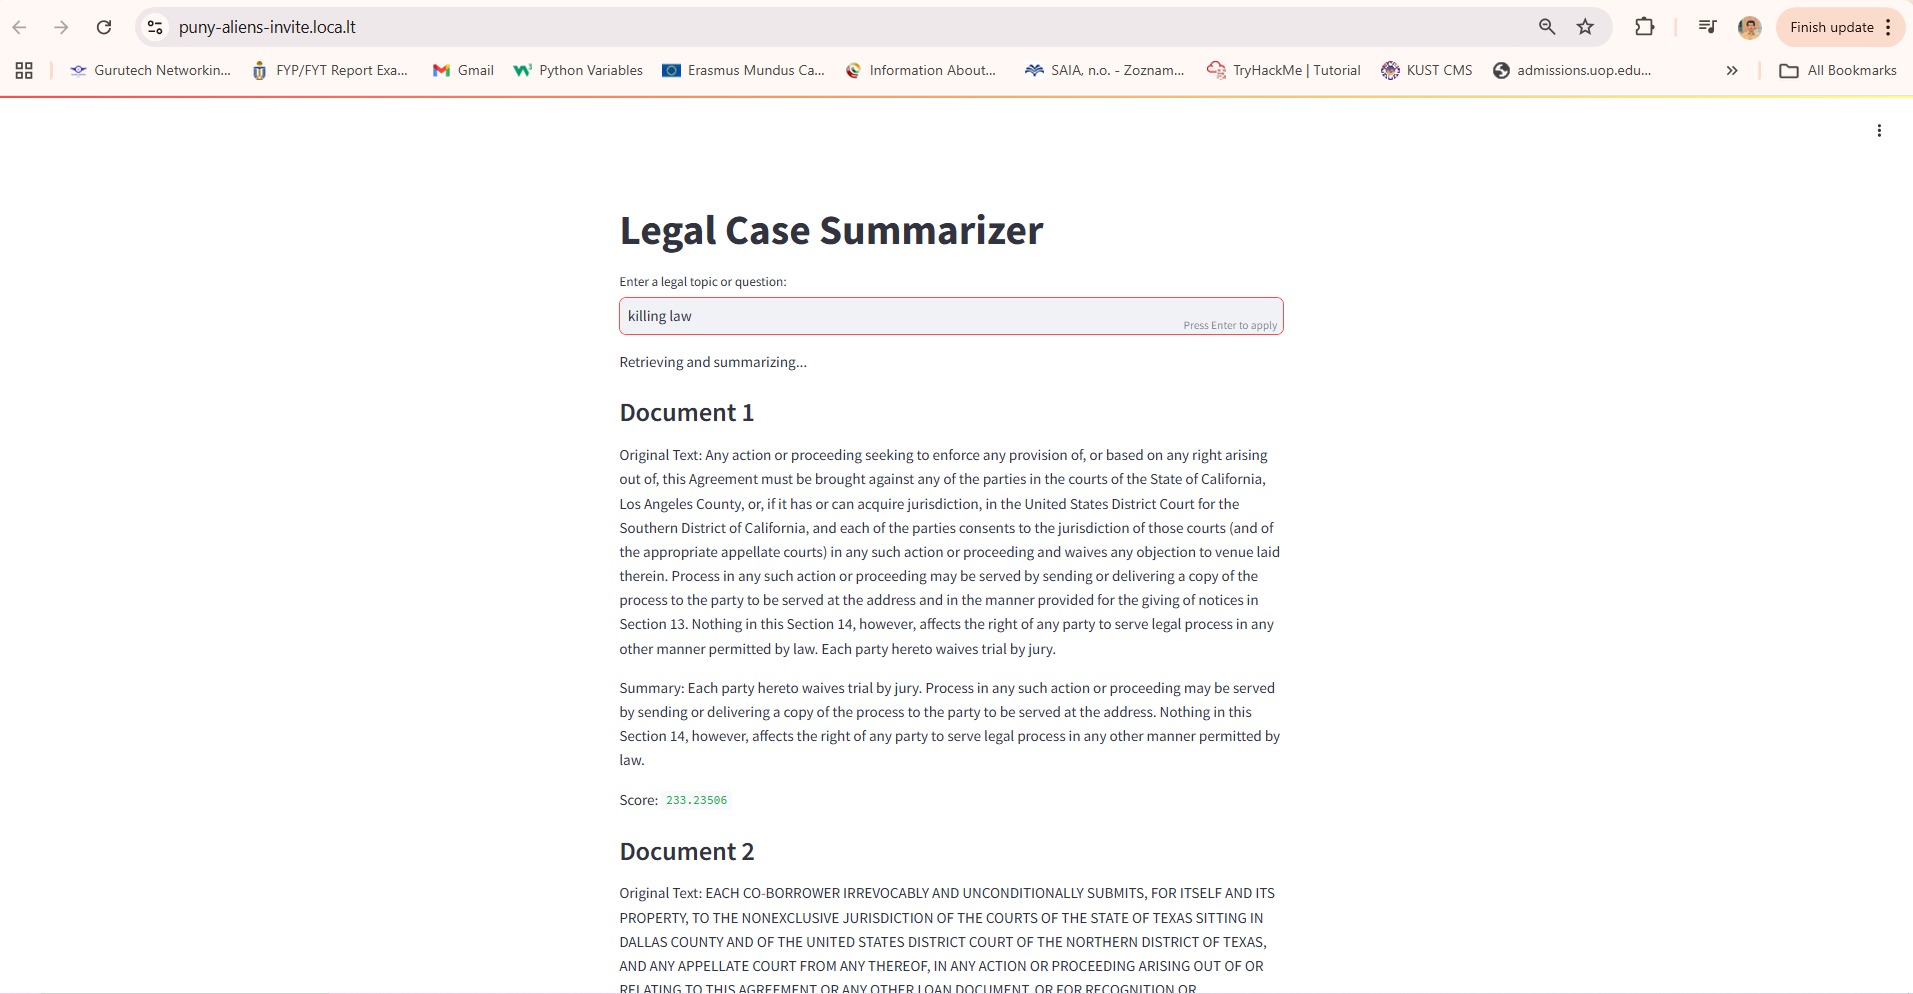

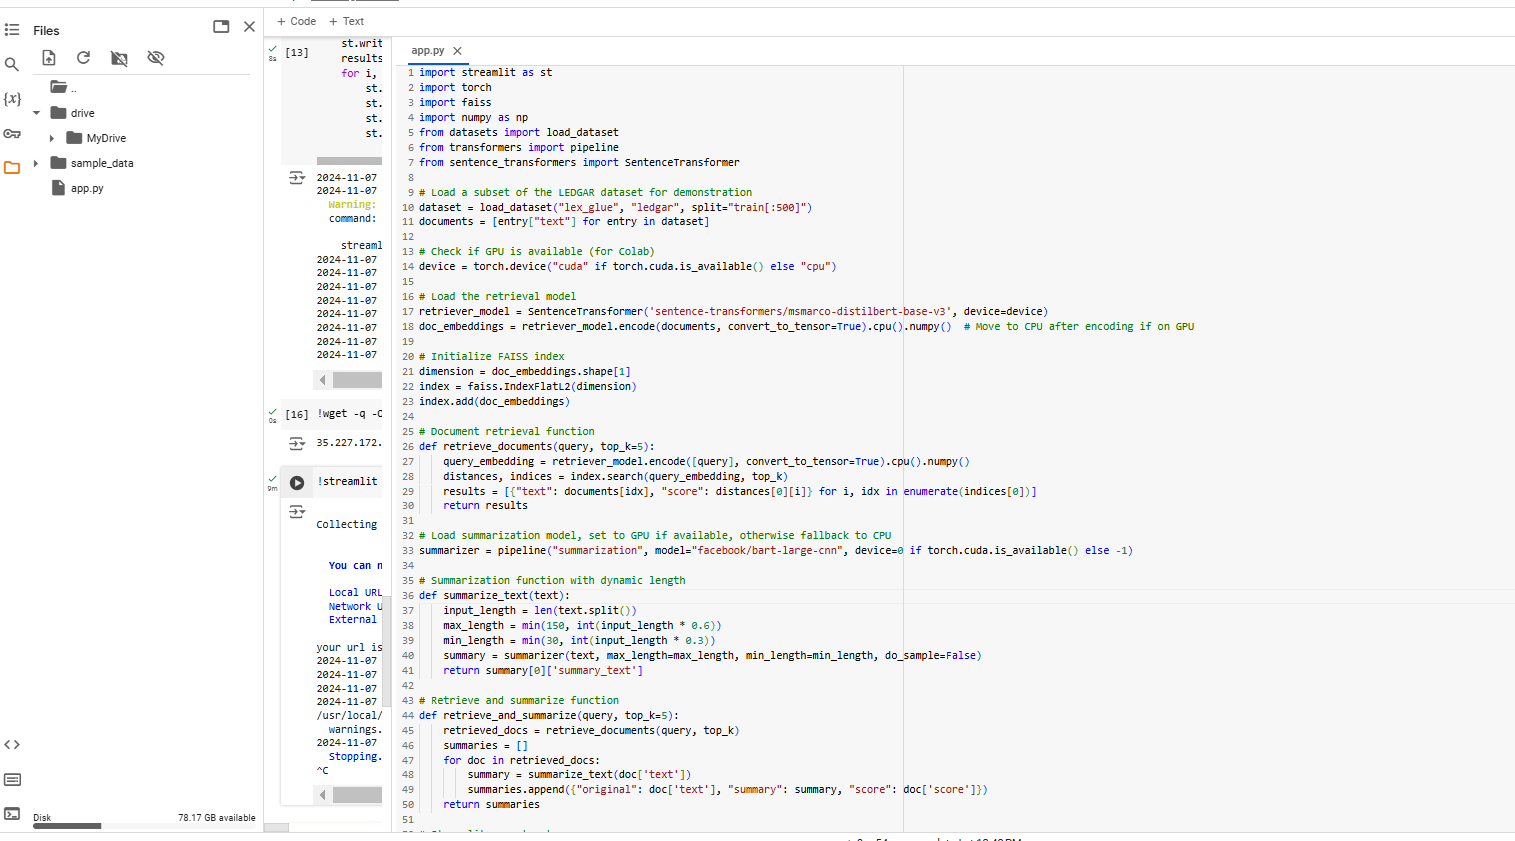